In [111]:
%matplotlib inline

# plotting
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt

# math and data manipulation
import numpy as np
import pandas as pd

# set random seeds 
from numpy.random import seed
from dateutil.parser import parse
import seaborn as sns

# modeling
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Bidirectional, GRU, Flatten

# progress bar
from tqdm import tqdm

In [49]:
train = pd.read_csv('../data/consumption_train.csv',parse_dates=['timestamp'],index_col=0)
train.head(5)

,series_id,timestamp,consumption,temperature
0,103088,2014-12-24 00:00:00,101842.233424,NaN
1,103088,2014-12-24 01:00:00,105878.048906,NaN
2,103088,2014-12-24 02:00:00,91619.105008,NaN
3,103088,2014-12-24 03:00:00,94473.706203,NaN
4,103088,2014-12-24 04:00:00,96976.755526,NaN


In [4]:
print (train.shape)
print (train.series_id.nunique())

(509376, 4)
758
count    758.0
mean     672.0
std        0.0
min      672.0
25%      672.0
50%      672.0
75%      672.0
max      672.0
Name: series_id, dtype: float64


In [16]:
test = pd.read_csv('../data/cold_start_test.csv',index_col=0,parse_dates=['timestamp'])
test.head(5)

,series_id,timestamp,consumption,temperature
0,102781,2013-02-27 00:00:00,15295.740389,17.00
1,102781,2013-02-27 01:00:00,15163.209562,18.25
2,102781,2013-02-27 02:00:00,15022.264079,18.00
3,102781,2013-02-27 03:00:00,15370.420458,17.00
4,102781,2013-02-27 04:00:00,15303.103213,16.90


In [22]:
print (test.shape)
print (test.series_id.nunique())
print (test.series_id.value_counts().describe())

(111984, 4)
625
count    625.000000
mean     179.174400
std       98.240727
min       24.000000
25%       96.000000
50%      168.000000
75%      264.000000
max      336.000000
Name: series_id, dtype: float64


In [17]:
print (train.timestamp.min(),train.timestamp.max(),test.timestamp.min(),test.timestamp.max())

2013-01-02 00:00:00 2017-12-29 23:00:00 2012-06-01 00:00:00 2017-12-03 23:00:00


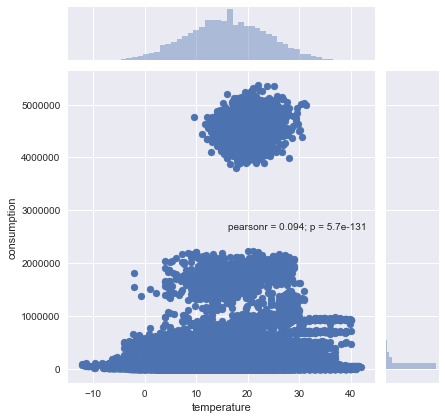

In [18]:
#test.temperature = np.log(test.temperature + test.temperature.min() + .00001)
sns.jointplot("temperature","consumption",data=test)
plt.show()

In [23]:
submission = pd.read_csv('../data/submission_format.csv',index_col=0,parse_dates=['timestamp'])
submission.head(5)

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03,19.931250,0.0,daily
1,102781,2013-03-04,20.034375,0.0,daily
2,102781,2013-03-05,19.189583,0.0,daily
3,102781,2013-03-06,18.397917,0.0,daily
4,102781,2013-03-07,20.762500,0.0,daily


In [24]:
print (submission.shape)
print (submission.series_id.nunique())
print (submission.series_id.value_counts().describe())

(7529, 5)
625
count    625.000000
mean      12.046400
std        9.709041
min        2.000000
25%        2.000000
50%        7.000000
75%       24.000000
max       24.000000
Name: series_id, dtype: float64


In [28]:
submission.groupby('series_id').prediction_window.first().value_counts()

hourly    242
weekly    192
daily     191
Name: prediction_window, dtype: int64

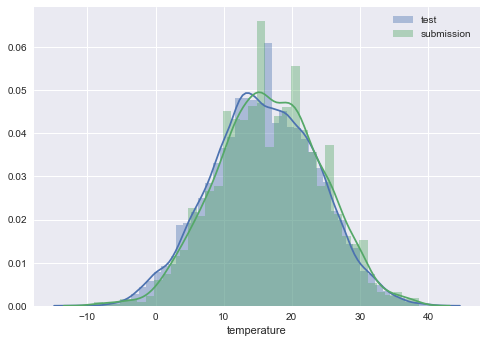

In [33]:
sns.distplot(test[pd.notnull(test.temperature) == True].temperature,kde=True,label='test')
sns.distplot(submission[pd.notnull(submission.temperature) == True].temperature,kde=True,label='submission')
plt.legend()
plt.show()

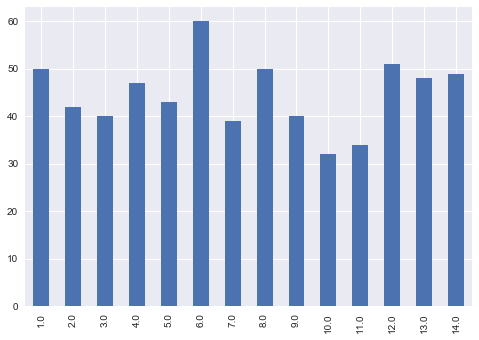

In [36]:
test.groupby('series_id').count().timestamp.divide(24).value_counts().sort_index().plot.bar()
plt.show()

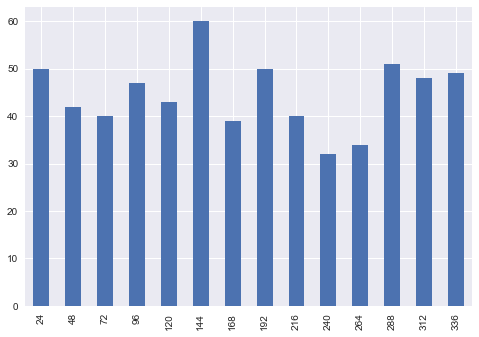

In [37]:
test.groupby('series_id').count().timestamp.value_counts().sort_index().plot.bar()
plt.show()

In [38]:
def create_lagged_features(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['consumption'])
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.consumption.shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

In [105]:
from sklearn.preprocessing import MinMaxScaler

def prepare_training_data(consumption_series, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    # scale training data
    scaler = MinMaxScaler(feature_range=(0, 1))
    consumption_vals = scaler.fit_transform(consumption_series.values.reshape(-1, 1))
    
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_vals, lag=lag)
    
    cols = list(consumption_lagged.columns)
    cols.remove('consumption')
    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('consumption', axis=1).values
    y = consumption_lagged.consumption.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    #X = X.reshape(X.shape[0], X.shape[1])
    
    return X, y, scaler

In [72]:
def prepare_training_data_without_scaling(consumption_series, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_series.values, lag=lag)
    
    cols = list(consumption_lagged.columns)
    cols.remove('consumption')
    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('consumption', axis=1).values
    y = consumption_lagged.consumption.values
    
    # keras expects 3 dimensional X
    #X = X.reshape(X.shape[0], 1, X.shape[1])
    X = X.reshape(X.shape[0], X.shape[1])
    
    return X, y, scaler, cols

In [73]:
train_lagged = pd.DataFrame()
for series_id, df in train.groupby('series_id'):
    X, y, scaler,cols = prepare_training_data_without_scaling(df.consumption,23)
    X = pd.DataFrame(X,columns=cols)
    X['target'] = y
    X['series_id'] = series_id
    
    train_lagged = pd.concat([train_lagged,X],axis=0)

In [74]:
train_lagged.head(3)

,consumption_1,consumption_2,consumption_3,consumption_4,consumption_5,consumption_6,consumption_7,consumption_8,consumption_9,consumption_10,...,consumption_16,consumption_17,consumption_18,consumption_19,consumption_20,consumption_21,consumption_22,consumption_23,target,series_id
0,200097.048151,203128.821608,206160.595065,209192.368522,227383.009263,236478.329633,239510.103090,254668.970374,254668.970374,257700.743831,...,251637.196918,187969.954324,191001.727781,191001.727781,187969.954324,187969.954324,191001.727781,187969.954324,194033.501238,100003
1,194033.501238,200097.048151,203128.821608,206160.595065,209192.368522,227383.009263,236478.329633,239510.103090,254668.970374,254668.970374,...,242541.876547,251637.196918,187969.954324,191001.727781,191001.727781,187969.954324,187969.954324,191001.727781,191001.727781,100003
2,191001.727781,194033.501238,200097.048151,203128.821608,206160.595065,209192.368522,227383.009263,236478.329633,239510.103090,254668.970374,...,281954.931486,242541.876547,251637.196918,187969.954324,191001.727781,191001.727781,187969.954324,187969.954324,194033.501238,100003


In [75]:
print (train_lagged.shape)

(491942, 25)


In [76]:
test_lagged = pd.DataFrame()
for series_id, df in test.groupby('series_id'):
    X, y, scaler,cols = prepare_training_data_without_scaling(df.consumption,23)
    X = pd.DataFrame(X,columns=cols)
    X['target'] = y
    X['series_id'] = series_id
    
    test_lagged = pd.concat([test_lagged,X],axis=0)

In [77]:
test_lagged.head(3)

,consumption_1,consumption_2,consumption_3,consumption_4,consumption_5,consumption_6,consumption_7,consumption_8,consumption_9,consumption_10,...,consumption_16,consumption_17,consumption_18,consumption_19,consumption_20,consumption_21,consumption_22,consumption_23,target,series_id
0,347356.567282,337365.610255,418245.901681,450213.840771,456573.852102,422485.909235,411995.209145,435202.027654,398619.273712,401762.189072,...,294258.866790,231587.963239,229620.224927,222826.842658,208346.006546,265999.958249,295668.298399,302766.211597,319655.965444,100004
1,319655.965444,347356.567282,337365.610255,418245.901681,450213.840771,456573.852102,422485.909235,411995.209145,435202.027654,398619.273712,...,313448.219578,294258.866790,231587.963239,229620.224927,222826.842658,208346.006546,265999.958249,295668.298399,305190.746303,100004
2,305190.746303,319655.965444,347356.567282,337365.610255,418245.901681,450213.840771,456573.852102,422485.909235,411995.209145,435202.027654,...,353009.910687,313448.219578,294258.866790,231587.963239,229620.224927,222826.842658,208346.006546,265999.958249,301423.152114,100004


In [78]:
print (test_lagged.shape)

(97609, 25)


In [67]:
meta = pd.read_csv('../data/meta.csv')

In [68]:
meta.head(3)

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
0,100003,x-large,low,False,False,False,False,False,True,True
1,100004,x-large,low,False,False,False,False,False,True,True
2,100006,x-small,low,False,False,False,False,False,True,True


In [79]:
train_lagged.to_csv('../data/train_lagged.csv',index=False)
test_lagged.to_csv('../data/test_lagged.csv',index=False)

In [118]:
lag =  24

# model parameters
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series

model.add(LSTM(24, return_sequences=True,stateful=True, batch_input_shape = batch_input_shape))
model.add(LSTM(12, return_sequences=True,stateful=True))

model.add(Flatten())
#model.add(LSTM(units=10, 
#              batch_input_shape=(batch_size,23,lag), 
#              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

In [119]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (1, 1, 24)                4704      
_________________________________________________________________
lstm_28 (LSTM)               (1, 1, 12)                1776      
_________________________________________________________________
flatten_2 (Flatten)          (1, 12)                   0         
_________________________________________________________________
dense_6 (Dense)              (1, 1)                    13        
Total params: 6,493
Trainable params: 6,493
Non-trainable params: 0
_________________________________________________________________


In [122]:
num_training_series = train.series_id.nunique()
epoch = 1

for i in tqdm(range(epoch), 
              total=epoch, 
              desc='Learning Consumption Trends - Epoch'):
        
    count = 0    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in train.groupby('series_id'):

        count += 1
        if count%100 == 0:
            print ("count = {}".format(count))
        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.consumption, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()






Learning Consumption Trends - Epoch:   0%|               | 0/1 [00:00<?, ?it/s]

count = 100
count = 200
count = 300
count = 400
count = 500
count = 600
count = 700







Learning Consumption Trends - Epoch: 100%|█████| 1/1 [17:35<00:00, 1055.48s/it]






In [123]:
def generate_hourly_forecast(num_pred_hours, consumption, model, scaler, lag):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = scaler.transform(consumption.values.reshape(-1, 1))[-lag:]
    
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.reshape(1, 1, lag), batch_size=1)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

    # revert scale back to original range
    hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    return hourly_preds

In [124]:
my_submission = pd.read_csv('../data/submission_format.csv')
my_submission.head(3)

,pred_id,series_id,timestamp,temperature,consumption,prediction_window
0,0,102781,2013-03-03 00:00:00,19.931250,0.0,daily
1,1,102781,2013-03-04 00:00:00,20.034375,0.0,daily
2,2,102781,2013-03-05 00:00:00,19.189583,0.0,daily


In [126]:
%%time
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = test[test.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds






Forecasting from Cold Start Data:   0%|                | 0/625 [00:00<?, ?it/s]




Forecasting from Cold Start Data:   0%|        | 1/625 [00:00<09:19,  1.12it/s]




Forecasting from Cold Start Data:   0%|        | 2/625 [00:01<08:36,  1.21it/s]




Forecasting from Cold Start Data:   0%|        | 3/625 [00:02<07:37,  1.36it/s]




Forecasting from Cold Start Data:   1%|        | 4/625 [00:03<08:46,  1.18it/s]




Forecasting from Cold Start Data:   1%|        | 5/625 [00:04<08:54,  1.16it/s]




Forecasting from Cold Start Data:   1%|        | 6/625 [00:04<07:56,  1.30it/s]




Forecasting from Cold Start Data:   1%|        | 7/625 [00:05<07:36,  1.35it/s]




Forecasting from Cold Start Data:   1%|        | 8/625 [00:06<07:46,  1.32it/s]




Forecasting from Cold Start Data:   1%|        | 9/625 [00:06<07:54,  1.30it/s]




Forecasting from Cold Start Data:   2%|       | 10/625 [00:07<07:35,  1.35it/s]




Forecasting from Cold Start Data:   2%|       | 11/625 [00:08<07:35,  1

Forecasting from Cold Start Data:  16%|█      | 98/625 [01:02<05:37,  1.56it/s]




Forecasting from Cold Start Data:  16%|█      | 99/625 [01:03<05:38,  1.55it/s]




Forecasting from Cold Start Data:  16%|▉     | 100/625 [01:03<05:35,  1.56it/s]




Forecasting from Cold Start Data:  16%|▉     | 101/625 [01:04<05:33,  1.57it/s]




Forecasting from Cold Start Data:  16%|▉     | 102/625 [01:04<05:31,  1.58it/s]




Forecasting from Cold Start Data:  16%|▉     | 103/625 [01:05<05:33,  1.56it/s]




Forecasting from Cold Start Data:  17%|▉     | 104/625 [01:06<05:31,  1.57it/s]




Forecasting from Cold Start Data:  17%|█     | 105/625 [01:06<05:31,  1.57it/s]




Forecasting from Cold Start Data:  17%|█     | 106/625 [01:07<05:32,  1.56it/s]




Forecasting from Cold Start Data:  17%|█     | 107/625 [01:09<05:34,  1.55it/s]




Forecasting from Cold Start Data:  17%|█     | 108/625 [01:09<05:32,  1.55it/s]




Forecasting from Cold Start Data:  17%|█     | 109/625 [01:09<05:30,  1.56it

Forecasting from Cold Start Data:  32%|█▉    | 197/625 [02:07<04:37,  1.54it/s]




Forecasting from Cold Start Data:  32%|█▉    | 198/625 [02:08<04:36,  1.54it/s]




Forecasting from Cold Start Data:  32%|█▉    | 199/625 [02:08<04:35,  1.54it/s]




Forecasting from Cold Start Data:  32%|█▉    | 200/625 [02:09<04:35,  1.54it/s]




Forecasting from Cold Start Data:  32%|█▉    | 201/625 [02:09<04:34,  1.55it/s]




Forecasting from Cold Start Data:  32%|█▉    | 202/625 [02:10<04:33,  1.55it/s]




Forecasting from Cold Start Data:  32%|█▉    | 203/625 [02:10<04:32,  1.55it/s]




Forecasting from Cold Start Data:  33%|█▉    | 204/625 [02:11<04:31,  1.55it/s]




Forecasting from Cold Start Data:  33%|█▉    | 205/625 [02:12<04:31,  1.55it/s]




Forecasting from Cold Start Data:  33%|█▉    | 206/625 [02:13<04:30,  1.55it/s]




Forecasting from Cold Start Data:  33%|█▉    | 207/625 [02:13<04:30,  1.55it/s]




Forecasting from Cold Start Data:  33%|█▉    | 208/625 [02:14<04:28,  1.55it

Forecasting from Cold Start Data:  48%|██▊   | 299/625 [03:08<03:25,  1.58it/s]




Forecasting from Cold Start Data:  48%|██▉   | 300/625 [03:09<03:25,  1.58it/s]




Forecasting from Cold Start Data:  48%|██▉   | 301/625 [03:10<03:24,  1.58it/s]




Forecasting from Cold Start Data:  48%|██▉   | 302/625 [03:10<03:23,  1.58it/s]




Forecasting from Cold Start Data:  48%|██▉   | 303/625 [03:11<03:23,  1.58it/s]




Forecasting from Cold Start Data:  49%|██▉   | 304/625 [03:12<03:23,  1.58it/s]




Forecasting from Cold Start Data:  49%|██▉   | 305/625 [03:12<03:22,  1.58it/s]




Forecasting from Cold Start Data:  49%|██▉   | 306/625 [03:14<03:22,  1.58it/s]




Forecasting from Cold Start Data:  49%|██▉   | 307/625 [03:14<03:21,  1.58it/s]




Forecasting from Cold Start Data:  49%|██▉   | 308/625 [03:15<03:21,  1.58it/s]




Forecasting from Cold Start Data:  49%|██▉   | 309/625 [03:16<03:20,  1.58it/s]




Forecasting from Cold Start Data:  50%|██▉   | 310/625 [03:16<03:19,  1.58it

Forecasting from Cold Start Data:  64%|███▊  | 398/625 [04:09<02:22,  1.59it/s]




Forecasting from Cold Start Data:  64%|███▊  | 399/625 [04:10<02:21,  1.60it/s]




Forecasting from Cold Start Data:  64%|███▊  | 400/625 [04:10<02:20,  1.60it/s]




Forecasting from Cold Start Data:  64%|███▊  | 401/625 [04:11<02:20,  1.60it/s]




Forecasting from Cold Start Data:  64%|███▊  | 402/625 [04:12<02:20,  1.59it/s]




Forecasting from Cold Start Data:  64%|███▊  | 403/625 [04:13<02:19,  1.59it/s]




Forecasting from Cold Start Data:  65%|███▉  | 404/625 [04:14<02:19,  1.59it/s]




Forecasting from Cold Start Data:  65%|███▉  | 405/625 [04:15<02:18,  1.59it/s]




Forecasting from Cold Start Data:  65%|███▉  | 406/625 [04:16<02:18,  1.59it/s]




Forecasting from Cold Start Data:  65%|███▉  | 407/625 [04:16<02:17,  1.58it/s]




Forecasting from Cold Start Data:  65%|███▉  | 408/625 [04:16<02:16,  1.59it/s]




Forecasting from Cold Start Data:  65%|███▉  | 409/625 [04:17<02:16,  1.59it

Forecasting from Cold Start Data:  79%|████▊ | 496/625 [05:17<01:22,  1.56it/s]




Forecasting from Cold Start Data:  80%|████▊ | 497/625 [05:18<01:21,  1.56it/s]




Forecasting from Cold Start Data:  80%|████▊ | 498/625 [05:19<01:21,  1.56it/s]




Forecasting from Cold Start Data:  80%|████▊ | 499/625 [05:19<01:20,  1.56it/s]




Forecasting from Cold Start Data:  80%|████▊ | 500/625 [05:20<01:20,  1.56it/s]




Forecasting from Cold Start Data:  80%|████▊ | 501/625 [05:21<01:19,  1.56it/s]




Forecasting from Cold Start Data:  80%|████▊ | 502/625 [05:22<01:18,  1.56it/s]




Forecasting from Cold Start Data:  80%|████▊ | 503/625 [05:22<01:18,  1.56it/s]




Forecasting from Cold Start Data:  81%|████▊ | 504/625 [05:23<01:17,  1.56it/s]




Forecasting from Cold Start Data:  81%|████▊ | 505/625 [05:24<01:17,  1.56it/s]




Forecasting from Cold Start Data:  81%|████▊ | 506/625 [05:24<01:16,  1.56it/s]




Forecasting from Cold Start Data:  81%|████▊ | 507/625 [05:25<01:15,  1.56it

Forecasting from Cold Start Data:  95%|█████▋| 593/625 [06:29<00:21,  1.52it/s]




Forecasting from Cold Start Data:  95%|█████▋| 594/625 [06:30<00:20,  1.52it/s]




Forecasting from Cold Start Data:  95%|█████▋| 595/625 [06:32<00:19,  1.52it/s]




Forecasting from Cold Start Data:  95%|█████▋| 596/625 [06:33<00:19,  1.51it/s]




Forecasting from Cold Start Data:  96%|█████▋| 597/625 [06:35<00:18,  1.51it/s]




Forecasting from Cold Start Data:  96%|█████▋| 598/625 [06:35<00:17,  1.51it/s]




Forecasting from Cold Start Data:  96%|█████▊| 599/625 [06:36<00:17,  1.51it/s]




Forecasting from Cold Start Data:  96%|█████▊| 600/625 [06:37<00:16,  1.51it/s]




Forecasting from Cold Start Data:  96%|█████▊| 601/625 [06:38<00:15,  1.51it/s]




Forecasting from Cold Start Data:  96%|█████▊| 602/625 [06:39<00:15,  1.51it/s]




Forecasting from Cold Start Data:  96%|█████▊| 603/625 [06:40<00:14,  1.51it/s]




Forecasting from Cold Start Data:  97%|█████▊| 604/625 [06:40<00:13,  1.51it

Wall time: 6min 52s


In [128]:
my_submission.tail(5)

,pred_id,series_id,timestamp,temperature,consumption,prediction_window
7524,7524,102154,2017-08-27 19:00:00,32.666667,45944.675051,hourly
7525,7525,102154,2017-08-27 20:00:00,29.900000,45944.675051,hourly
7526,7526,102154,2017-08-27 21:00:00,28.000000,45944.675051,hourly
7527,7527,102154,2017-08-27 22:00:00,26.666667,45944.675051,hourly
7528,7528,102154,2017-08-27 23:00:00,27.300000,45944.675051,hourly


In [132]:
my_submission.to_csv("../data/submmission1.csv",index=False)